# Parameterize the kinetic rates of the model

## Conduct a simulation

In [1]:
# define the environment path 
import os
local_cobrakbase_path = os.path.join('C:', 'Users', 'Andrew Freiburger','Documents','Argonne','cobrakbase')
os.environ["HOME"] = local_cobrakbase_path

# import the models
import cobrakbase
token = 'RBP7R34IILI6IQN5533VVSVUZM6H7YU7'
kbase_api = cobrakbase.KBaseAPI(token)
# model1 = kbase_api.get_from_ws("iML1515",76994)
# model2 = kbase_api.get_from_ws("iSB1139.kb.gf",30650)

C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


cobrakbase 0.2.8


C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\site-packages\cobra\medium\minimal_medium.py:112: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  medium = pd.Series()
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\site-packages\cobra\medium\minimal_medium.py:112: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  medium = pd.Series()


The ['B2', 'B3', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'G11', 'G12'] trials were dropped from the OD measurements.
The ['B2', 'B3', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'G11', 'G12'] trials were dropped from the pf measurements.
The ['B2', 'B3', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'C2', 'C3', 'C

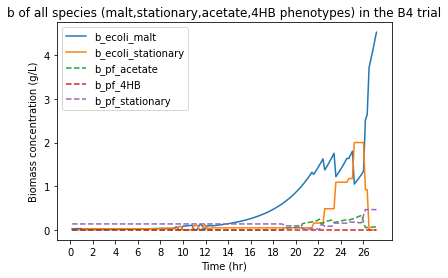

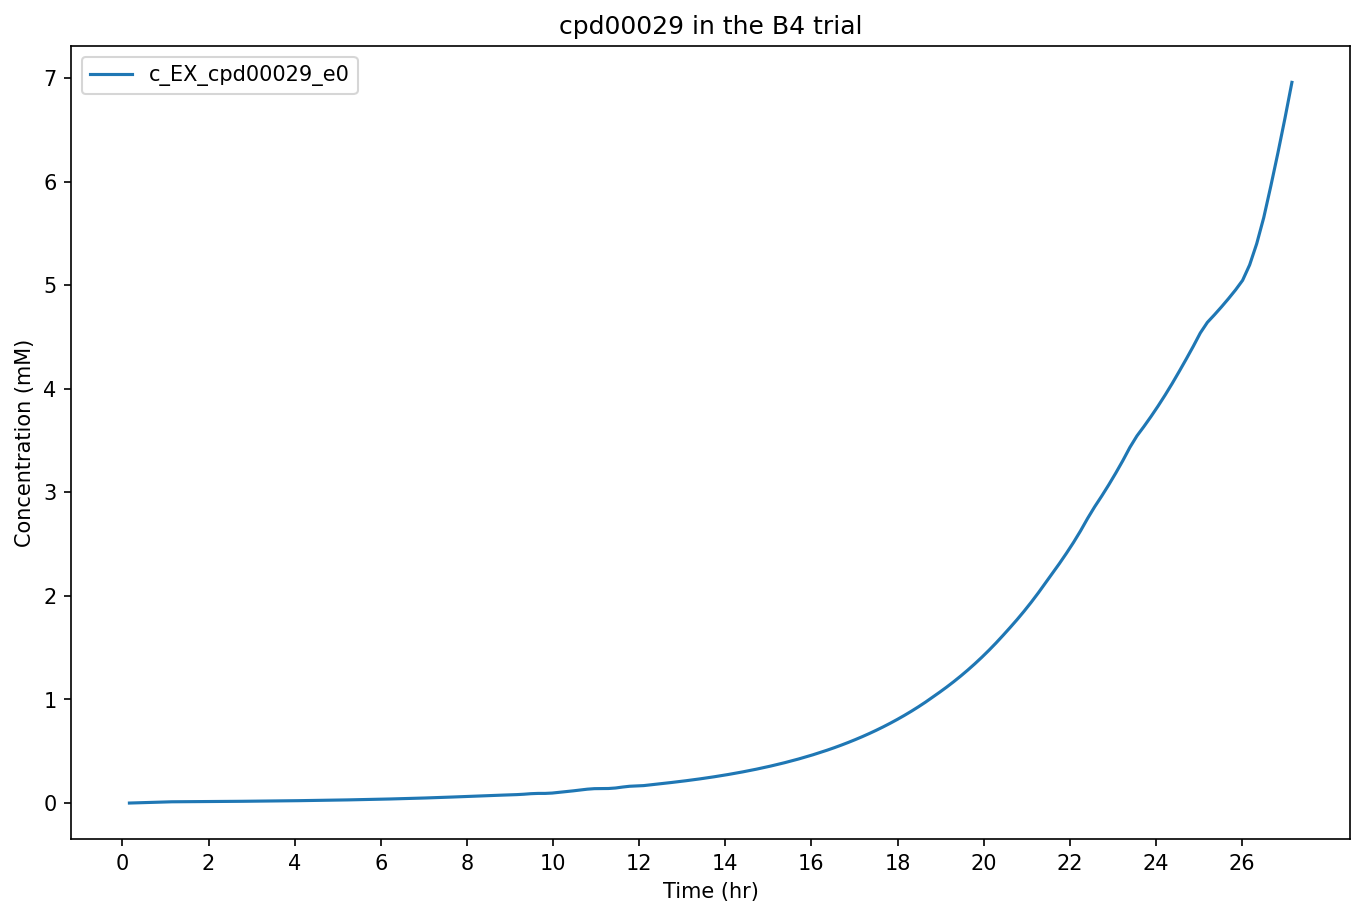

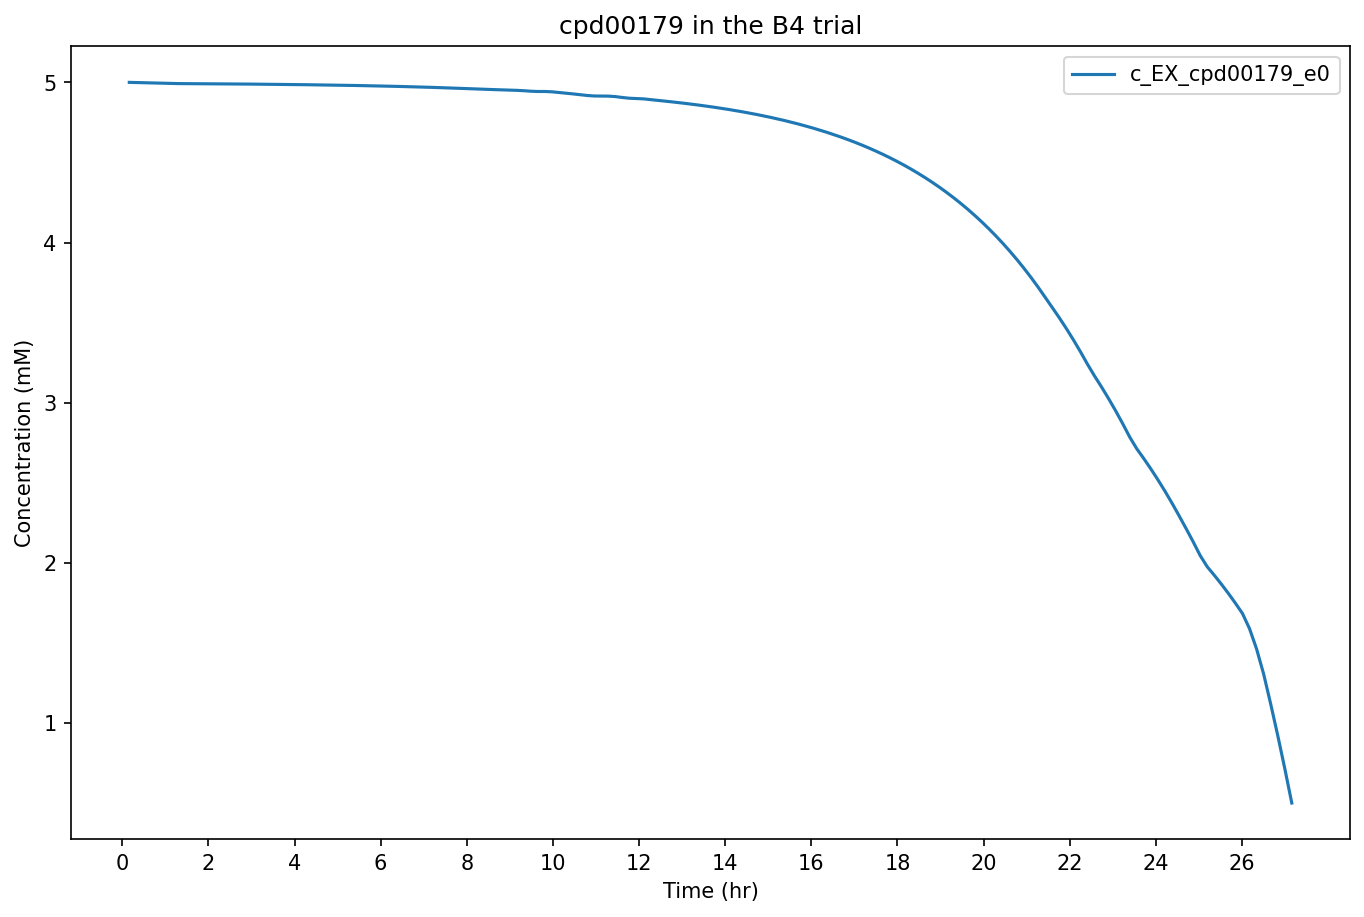

In [3]:
from datetime import datetime
from time import process_time
from pandas import set_option
set_option("display.max_rows", None)
# import the KBase objects
graphs = [
    {
        'trial':'B4',
        'content': 'biomass',
        # "species": ["ecoli"],
        'experimental_data': True
    },
    {
        'trial':'B4',
        'content': "cpd00029",
    },
    {
        'trial':'B4',
        'content': "cpd00179",
    }
]

%run MSCommFitting.py
time1 = process_time()
mscommfit = MSCommFitting()
mscommfit.load_data(#phenotypes_csv_path = 'PhenotypeStoichiometry.csv', 
                    community_members = {
                        kbase_api.get_from_ws("iML1515",76994): {
                            'name': 'ecoli', 
                            'phenotypes': {#'acetate': kbase_api.get_from_ws('93465/13/1'), 
                                        'malt': {"cpd00179":[-1,-1]} #kbase_api.get_from_ws("93465/23/1")} #'93465/9/1')}   # !!! The phenotype name must align with the experimental IDs for the graphs to find the appropriate data
                            }
                        },
                        kbase_api.get_from_ws("iSB1139.kb.gf",30650): {
                            'name': 'pf',
                            'phenotypes': {'acetate': {"cpd00029":[-1,-1]}, # kbase_api.get_from_ws("93465/25/1"), #'93465/11/1'), 
                                        '4HB': {"cpd00136":[-1,-1]} # kbase_api.get_from_ws('	93465/27/1')} #93465/15/1')}
                            }
                        }
                    },
                    base_media = kbase_api.get_from_ws("93465/19/1"),
                    signal_csv_paths = {'path':'Jeffs_data/PF-EC 4-29-22 ratios and 4HB changes (1).xlsx', 'Raw OD(590)':'OD', 'mNeonGreen':'pf', 'mRuby':'ecoli'},
                    carbon_conc_series = {'rows': {
                        'cpd00136': {'B':0, 'C': 0, 'D': 1, 'E': 1, 'F': 4, 'G': 4},
                        'cpd00179': {'B':5, 'C': 5, 'D':5, 'E': 5, 'F': 5, 'G': 5},
                        }},
                    ignore_trials = {'rows': ['C', 'D', 'E', 'F', 'G'], 'columns': [1,2,3,5,6,7,8,9,10,11,12]}, # 'wells': ['C2', 'G3', 'C12']}
                   # ignore_timesteps = [x for x in range(20,167)],
                    # zip_path='mscomfit.zip'
                   )
time2 = process_time()
print(datetime.today(), (time2-time1)/60, 'minutes later')
mscommfit.define_problem(parameters={
                                    'v':.3,
                                    'cvmin': 100,
                                    'bcv': 100,
                                    'diffpos': 100,
                                    'diffneg': 100
                                    }, 
                         export_zip_name='for_michaelis_menten.zip', 
                         final_relative_carbon_conc = 0.1, 
                         metabolites_to_track = ["cpd00179","cpd00029","cpd00136"], 
                         bad_data_timesteps = {'*':'23:'}, zero_start=["cpd00029"])
print(datetime.today())
%time mscommfit.compute(graphs) #, zip_name='simple_full_community.zip')
print('growth Vmax:', mscommfit.parameters['v'], 'objective value:', mscommfit.problem.objective.value, '\n\n\n\n')

## Change the parameters

### crude, universal, Vmax

In [ ]:
from numpy import linspace

for vmax in linspace(.1,.4,10):
    mscommfit.change_parameters(vmax=-vmax, export_zip_name='michaelis_menten_edited.zip', extract_zip_name='for_michaelis_menten.zip')
    %time mscommfit.compute(graphs, 'michaelis_menten_edited.zip')
    print(datetime.today())
    print('growth Vmax:', vmax, 'objective value:', mscommfit.problem.objective.value, '\n\n\n\n')

### specified trial-time dependent Vmax

In [ ]:
from numpy import linspace

vmax_values = {}
km_values = {}
for var, content in mscommfit.variables.items():
    if isinstance(var, dict):
        for time in content.keys():
            vmax_values[time] = {trial:2.2667 for trial in content2}
            km_values[time] = {trial:2 for trial in content2}

mscommfit.change_parameters(vmax=vmax_values, km=km_values, strain='ecoli_malt', graphs=graphs, export_zip_name='simple_full_community_edited.zip', extract_zip_name='simple_full_community.zip')
%time mscommfit.compute(graphs, 'michaelis_menten_edited.zip')
print(datetime.today())
print('growth Vmax:', vmax, 'objective value:', mscommfit.problem.objective.value, '\n\n\n\n')